In [1]:
using HDF5
using Printf
using DataFrames
using CSV
using ArgParse
using Random
using LinearAlgebra
using QAOA

using Flux 
#using GeometricFlux 
using Graphs
using Statistics
#using GeometricFlux: GraphConv
#using GraphSignals
#using GeometricFlux: edge_list_graph

using Zygote
using GraphNeuralNetworks
using SimpleWeightedGraphs 
using Revise
using MLUtils
using Flux: DataLoader
using Flux.Losses: logitbinarycrossentropy, binarycrossentropy
using Flux: @functor

In [2]:
N = 14
#idx = 1

PATH = raw"/home/ubuntu/MAX2SAT//MAX2SATQuantumData/Mirkarimi_data/HDF5/"
#file_name = PATH * @sprintf("/max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.h5", idx, N, 3N)

#J_mat = h5read(file_name, "coupling_matrix"); 
#local_fields = h5read(file_name, "local_fields")
#println(local_fields)

PATH_N10 = @sprintf("/home/ubuntu/aqc_GNN/MAX2SAT_data/N_%i/", 10);
PATH_N12 = @sprintf("/home/ubuntu/aqc_GNN/MAX2SAT_data/N_%i/", 12);
PATH_N14 = @sprintf("/home/ubuntu/aqc_GNN/MAX2SAT_data/N_%i/", 14);
PATH_N16 = @sprintf("/home/ubuntu/aqc_GNN/MAX2SAT_data/N_%i/", 16);

In [ ]:
function load_single_instance(file_path::String, n::Int)
    
    J = h5read(file_path, "couplings"); 
    local_fields = h5read(file_path, "local_fields")
    bitstring = h5read(file_path, "solution_bitstring")

    # Create DataFrame for the single instance
    df = DataFrame()
    
    # add ground state energy
    df[!, Symbol("solution_bitstring")] = [bitstring]

    # Add local fields columns
    for i in 1:n
        df[!, Symbol("h$i")] = [local_fields[i]]
    end
    
    # Add couplings matrix columns (upper triangle only)
    for i in 1:n
        for j in i+1:n
            df[!, Symbol("J_$(i)_$(j)")] = [J[i, j]]
        end
    end

    return df
end


function load_dataset(instance_files::Vector{String}, n::Int)
    all_instances = DataFrame()

    for (instance_path) in instance_files
        df = load_single_instance(instance_path, n)
        
        # Append to the main DataFrame
        append!(all_instances, df)

    end

    return all_instances
end


function df_to_training_data(df::DataFrame, N::Int)
    training_data = []

    for row in eachrow(df)
        # 1. Extract h vector
        h = [row[Symbol("h$i")] for i in 1:N]

        # 2. Build full symmetric J matrix from upper triangle
        J = zeros(N, N)
        for i in 1:N
            for j in i+1:N
                key = Symbol("J_$(i)_$(j)")
                J[i, j] = row[key]
                J[j, i] = row[key]
            end
        end

        # 3. Extract solution bitstring and convert to Float32
        z = Float32.(row.solution_bitstring)
        J = Float32.(J)
        h = Float32.(h)

        # 4. Append (J, h, z) tuple
        push!(training_data, (J, h, z))
    end

    return training_data
end

df_to_training_data (generic function with 1 method)

In [4]:
instance_files = readdir(PATH_N10)
instance_files = instance_files[1:2000]

full_path_instance = [joinpath(PATH_N10, file) for file in instance_files]

df_10 = load_dataset(full_path_instance, 10)

instance_files = readdir(PATH_N12)
instance_files = instance_files[1:2000]

full_path_instance = [joinpath(PATH_N12, file) for file in instance_files]

df_12 = load_dataset(full_path_instance, 12)



instance_files = readdir(PATH_N14)
instance_files = instance_files[1:2000]

full_path_instance = [joinpath(PATH_N14, file) for file in instance_files]

df_14 = load_dataset(full_path_instance, 14)


instance_files = readdir(PATH_N16)
instance_files = instance_files[1:1000]

full_path_instance = [joinpath(PATH_N16, file) for file in instance_files]

df_16 = load_dataset(full_path_instance, 16)

Row,solution_bitstring,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,J_1_2,J_1_3,J_1_4,J_1_5,J_1_6,J_1_7,J_1_8,J_1_9,J_1_10,J_1_11,J_1_12,J_1_13,J_1_14,J_1_15,J_1_16,J_2_3,J_2_4,J_2_5,J_2_6,J_2_7,J_2_8,J_2_9,J_2_10,J_2_11,J_2_12,J_2_13,J_2_14,J_2_15,J_2_16,J_3_4,J_3_5,J_3_6,J_3_7,J_3_8,J_3_9,J_3_10,J_3_11,J_3_12,J_3_13,J_3_14,J_3_15,J_3_16,J_4_5,J_4_6,J_4_7,J_4_8,J_4_9,J_4_10,J_4_11,J_4_12,J_4_13,J_4_14,J_4_15,J_4_16,J_5_6,J_5_7,J_5_8,J_5_9,J_5_10,J_5_11,J_5_12,J_5_13,J_5_14,J_5_15,J_5_16,J_6_7,J_6_8,J_6_9,J_6_10,J_6_11,J_6_12,J_6_13,J_6_14,J_6_15,J_6_16,J_7_8,J_7_9,J_7_10,J_7_11,J_7_12,J_7_13,J_7_14,J_7_15,⋯
,Array…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",-1.0,-0.0,3.0,-2.0,1.0,-0.0,4.0,6.0,2.0,3.0,-0.0,1.0,5.0,-0.0,-0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,⋯
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",2.0,-1.0,3.0,1.0,-0.0,2.0,-0.0,1.0,1.0,-0.0,-0.0,-0.0,1.0,3.0,2.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,-1.0,1.0,-1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,⋯
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.0,2.0,-1.0,-0.0,-0.0,1.0,1.0,-1.0,4.0,1.0,-2.0,-2.0,3.0,5.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,2.0,0.0,0.0,0.0,⋯
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",-1.0,1.0,-1.0,1.0,-1.0,-1.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,-0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,⋯
5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",3.0,1.0,1.0,2.0,1.0,1.0,-0.0,4.0,1.0,-2.0,1.0,1.0,4.0,-0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,-1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,⋯
6,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.0,-2.0,2.0,-0.0,-2.0,2.0,9.0,3.0,3.0,-0.0,-0.0,3.0,2.0,4.0,-0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.

In [5]:
#training_data = df_to_training_data(df, N)

training_data_10 = df_to_training_data(df_10, 10)
training_data_12 = df_to_training_data(df_12, 12)
training_data_14 = df_to_training_data(df_14, 14)
training_data_16 = df_to_training_data(df_16, 16)

println(training_data_10[1])

(Float32[0.0 1.0 0.0 1.0 1.0 0.0 -1.0 -1.0 0.0 0.0; 1.0 0.0 0.0 1.0 0.0 2.0 1.0 -1.0 -1.0 -1.0; 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0; 1.0 1.0 0.0 0.0 0.0 -1.0 -1.0 1.0 -1.0 0.0; 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0; 0.0 2.0 0.0 -1.0 0.0 0.0 1.0 0.0 1.0 1.0; -1.0 1.0 1.0 -1.0 0.0 1.0 0.0 0.0 0.0 1.0; -1.0 -1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 2.0; 0.0 -1.0 1.0 -1.0 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 -1.0 0.0 0.0 1.0 1.0 1.0 2.0 0.0 0.0], Float32[3.0, -0.0, -1.0, 2.0, 1.0, -0.0, 2.0, 3.0, 2.0, 4.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])


In [ ]:
function to_gnn(distance_matrix, node_features, targets)
    # Get all possible edges (including self-loops)
    n = size(distance_matrix, 1)
    rows, cols = Int[], Int[]
    edge_weights = Float32[]
    
    for i in 1:n, j in 1:n
        push!(rows, i)
        push!(cols, j)
        push!(edge_weights, distance_matrix[i,j])
    end

    # Create GNNGraph with edge features
    g = GNNGraph((rows, cols, edge_weights), 
                ndata = (
                    x = reshape(Float32.(node_features), 1, n),  
                    y = reshape(Float32.(targets), 1, n)           
                )
                )
    
    return g
end

to_gnn (generic function with 1 method)

In [ ]:
# 1. Proper model definition with gradient tracking
struct SKGNN
    message_layers::Chain
    update_layer::Chain
    readout_layer::Chain
end

@functor SKGNN  # Essential for parameter tracking

function SKGNN(node_dim=1, edge_dim=1, hidden_dim=64)
    message_layers = Chain(
        Dense(2*node_dim + edge_dim, hidden_dim, tanh),  # Changed to tanh
        Dense(hidden_dim, hidden_dim, tanh),
        Dense(hidden_dim, node_dim)
    )
    
    update_layer = Chain(
        Dense(2*node_dim, hidden_dim, tanh),
        Dense(hidden_dim, node_dim)
    )
    
    readout_layer = Chain(
        Dense(node_dim, hidden_dim, relu),
        Dense(hidden_dim, 1, tanh)  # Bounded output
    )
    
    return SKGNN(message_layers, update_layer, readout_layer)
end


# 2. Gradient-safe forward pass
function (model::SKGNN)(J::Matrix{Float32}, h::Vector{Float32}, num_iters::Int=10)
    n = size(J, 1)
    # Initialize node features as regular arrays (not Params)
    node_features = [Float32[h[i]] for i in 1:n]  # Each feature is a 1-element vector
    
    for _ in 1:num_iters
        # Message passing
        messages = [
            sum([
                model.message_layers(vcat(node_features[i], node_features[j], [J[i,j]]))
                for j in 1:n if i ≠ j
            ]) ./ (n-1)
            for i in 1:n
        ]
        
        # Node update - keep as regular arrays
        node_features = [
            tanh.(node_features[i] .+ model.update_layer(vcat(node_features[i], messages[i])))
            for i in 1:n
        ]
    end
    
    # Readout
    spins = [model.readout_layer(feat)[1] for feat in node_features]
    return vcat(spins...)
end

"""
function sk_loss(model, J, h, true_spins)
    pred_spins = model(J, h)
    #energy = -0.5f0 * dot(pred_spins, J * pred_spins) - dot(pred_spins, h)
    energy = -dot(h, pred_spins) - 0.5f0 * dot(pred_spins, J * pred_spins)

    binary_penalty = mean(abs.(pred_spins .^ 2 .- 1.0f0))
    return energy + 0.1f0 * binary_penalty
end


function sk_loss(model, J, h, true_spins)
    pred_spins = model(J, h)
    
    # Energy term
    energy = -dot(h, pred_spins) - 0.5f0 * dot(pred_spins, J * pred_spins)
    
    # Binary penalty (more aggressive)
    binary_penalty = mean((pred_spins .^ 2 .- 1.0f0) .^ 2)
    
    # Add similarity to ground truth (if available)
    similarity = mean(abs.(pred_spins .- true_spins))
    
    return energy + 0.5f0 * binary_penalty + 0.1f0 * similarity
end
"""

function sk_loss(model, J, h, true_spins)
    pred_spins = model(J, h)
    #energy = -0.5f0 * dot(pred_spins, J * pred_spins) - dot(pred_spins, h)
    energy = -dot(h, pred_spins) - 0.5f0 * dot(pred_spins, J * pred_spins)    
    energy_true = -dot(h, true_spins) - 0.5f0 * dot(true_spins, J * true_spins)

    energy_loss = (energy - energy_true)^2
    binary_penalty = mean(abs.(pred_spins .^ 2 .- 1.0f0))
    
    return energy_loss + 0.1f0 * binary_penalty
end



# 4. Training with gradient verification

function train_skgnn(model, data, epochs=100; lr=0.01)
    optimizer = ADAM(lr)
    ps = Flux.params(model)  # Get all trainable parameters
    
    for epoch in 1:epochs
        total_loss = 0.0f0
        for (J, h, true_spins) in data
            grads = gradient(ps) do
                sk_loss(model, J, h, true_spins)
            end

            # Proper gradient handling
            Flux.update!(optimizer, ps, grads)
            
            total_loss += sk_loss(model, J, h, true_spins)
        end
        avg_loss = total_loss / length(data)
        
        println("Epoch $epoch, Loss: $avg_loss")
        
        #if avg_loss < 0.1
        #    println("Converged!")
        #    break
        #end
    end

end


function train_skgnn_with_batch(model, data, epochs=100, lr=0.01, batchsize=32)
    optimizer = ADAM(lr)
    ps = Flux.params(model)

    N = length(data)
    loss_history = Float32[]  # Store average loss per epoch

    for epoch in 1:epochs
        total_loss = 0.0f0

        # Shuffle data for each epoch
        Random.seed!(123)
        shuffled_indices = randperm(N)
        data_shuffled = data[shuffled_indices]

        for batch_start in 1:batchsize:N
            batch_end = min(batch_start + batchsize - 1, N)
            #batch = data[batch_start:batch_end]
            batch = data_shuffled[batch_start:batch_end]

            grads = gradient(ps) do
                mean([sk_loss(model, J, h, spins) for (J,h,spins) in batch])
            end

            Flux.update!(optimizer, ps, grads)

            batch_loss = mean([sk_loss(model, J, h, spins) for (J,h,spins) in batch])
            total_loss += batch_loss
        end

        avg_loss = total_loss / ceil(Int, N / batchsize)
        push!(loss_history, avg_loss)  # Store epoch loss

        println("Epoch $epoch, Loss: $avg_loss")
    end

    return loss_history
end


train_skgnn_with_batch (generic function with 4 methods)

In [ ]:
function check_test_data(data, num_data, model)

    for i in 1:num_data
            
        J, h, spins = data[i]
        J = Float32.(J)
        h = Float32.(h)
        pred = model(J, h)

        println(spins)
        println(pred)

        println("True energy: ", -dot(h, spins) - 0.5 * dot(spins, J * spins))
        println("Pred energy: ", -dot(h, pred) - 0.5 * dot(pred, J * pred))

    end

end

check_test_data (generic function with 1 method)

In [ ]:
function check_test_data_save(data, num_data, model, N)

    #PATH = raw"/home/ubuntu/aqc_GNN/MAX2SAT_data/result_data/"
    PATH = @sprintf("/home/ubuntu/aqc_GNN/MAX2SAT_data/result_data/N_%i/", N)

    for i in 1:num_data
        
        idx = i
        J, h, spins = data[i]
        J = Float32.(J)
        h = Float32.(h)
        #model = SKGNN()
        pred = model(J, h)

        #println(spins)
        #println(pred)
        
        true_e = -dot(h, spins) - 0.5 * dot(spins, J * spins)
        pred_e = -dot(h, pred) - 0.5 * dot(pred, J * pred)

        #println("True energy: ", true_e)
        #println("Pred energy: ", pred_e)

        h5open(PATH * @sprintf("optimized_GNN_instance_N_%i_idx_%04i.h5", N, idx), "w") do file
            write(file, "true_energy", pred_e)           
            write(file, "true_spins", spins)                               
            write(file, "pred_energy", true_e)                    
            write(file, "pred_spins", pred)           
        end

    end

end

check_test_data_save (generic function with 1 method)

In [ ]:
function main()
    # Create synthetic data
    data_1 = training_data_10[1:250]
    data_2 = training_data_12[1:250]
    data_3 = training_data_14[1:250]
    data_4 = training_data_16[1:250]

    data_combined = vcat(data_1, data_2, data_3, data_4)


    Random.seed!(12)
    model = SKGNN()
    loss = train_skgnn_with_batch(model, data_combined, 20, 0.01, 32)
    
    
    # Test data
    check_test_data(data_1, 100, model)
    check_test_data(data_2, 100, model)
    check_test_data(data_3, 100, model)
    check_test_data(data_4, 100, model)

    # Save test data result
    check_test_data_save(data_1, 100, model, 10)
    check_test_data_save(data_2, 100, model, 12)
    check_test_data_save(data_3, 100, model, 14)
    check_test_data_save(data_4, 100, model, 16)

    return loss

end

losses = main()


Epoch 1, Loss: 145.06021
Epoch 2, Loss: 0.7572798
Epoch 3, Loss: 0.13476817
Epoch 4, Loss: 0.0714077
Epoch 5, Loss: 0.05106541
Epoch 6, Loss: 0.040417816
Epoch 7, Loss: 0.033828445
Epoch 8, Loss: 0.029343659
Epoch 9, Loss: 0.02607634
Epoch 10, Loss: 0.023570051
Epoch 11, Loss: 0.021567665
Epoch 12, Loss: 0.019915694
Epoch 13, Loss: 0.018517936
Epoch 14, Loss: 0.017310303
Epoch 15, Loss: 0.016249986
Epoch 16, Loss: 0.01530605
Epoch 17, Loss: 0.014457394
Epoch 18, Loss: 0.013687242
Epoch 19, Loss: 0.012983841
Epoch 20, Loss: 0.012336793


20-element Vector{Float32}:
 145.06021
   0.7572798
   0.13476817
   0.0714077
   0.05106541
   0.040417816
   0.033828445
   0.029343659
   0.02607634
   0.023570051
   0.021567665
   0.019915694
   0.018517936
   0.017310303
   0.016249986
   0.01530605
   0.014457394
   0.013687242
   0.012983841
   0.012336793

Loss plot

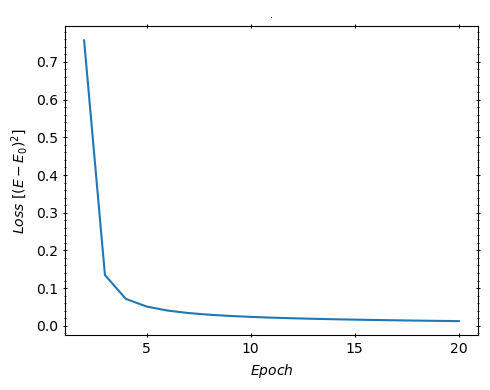

In [ ]:
using PyPlot


fig, ax = subplots(figsize=(5, 4))

 
#ax.plot(1:length(losses[1:20]), losses[1:20], linestyle="-")
ax.plot(2:length(losses), losses[2:20], linestyle="-")


ax.set_title(L".", fontsize=7)
#ax.legend(loc="upper right", fontsize=9)

#ax.set_xlim(9.5, 16.5) 
#ax.set_ylim(0.64, 1.01) 

ax.minorticks_on()

ax.tick_params(axis="x", which="major", direction="inout", bottom=true, top=true)
ax.tick_params(axis="x", which="minor", direction="inout", bottom=false, top=false)
ax.tick_params(axis="y", which="minor", direction="inout", left=true, right=true)


# Y-axis label
ax.set_ylabel(L"Loss \ [(E - E_0)^2]", fontsize=10)
ax.set_xlabel(L"Epoch", fontsize=10)

# Shared X-axis label
ax[:set_xticks]([ 5,10,15,20])

ax.tick_params(direction="inout", top=true, right=true)

tight_layout()

savefig("/home/ubuntu/Results_master/Loss_GNN_MAX2SAT_2.pdf")

display(fig)

In [ ]:
# Test single instance data

J, h, spins = training_data_10[4]#data[2]
J = Float32.(J)
h = - Float32.(h)

pred = model(J, h)

println(spins)
println(pred)

println("True energy: ", -dot(h, spins) - 0.5 * dot(spins, J * spins))
println("Pred energy: ", -dot(h, pred) - 0.5 * dot(pred, J * pred))

Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Float32[0.010987865, 0.052787, 0.03158383, 0.013763525, 0.052756436, 0.02163997, 0.04103944, 0.040347178, 0.05552916, 0.031363726]
True energy: 2.0
Pred energy: 0.7061453582718968


In [81]:
function energies_and_bitstrings_qaoa(annealing_problem)
    L = annealing_problem.num_qubits
    h = annealing_problem.local_fields
    J = annealing_problem.couplings
    
    bit_string_df = DataFrame( bit_string = [], energy = Float64[]);
    
    bitstrings = [string(i, base=2, pad=L) |> reverse for i in 0:(2^L - 1)]
    bitvals = [parse.(Int, [bitstring[j] for j in 1:L]) for bitstring in bitstrings]
    spins = [1 .- 2s for s in bitvals]
    
    for spin in spins
        energy = sum([-h[l] * spin[l] for l in 1:L]) + sum([-J[i, j] * spin[i] * spin[j] for i in 1:L for j in (i+1):L])
        #energy = sum([h[l] * spin[l] for l in 1:L]) + sum([-J[i, j] * spin[i] * spin[j] for i in 1:L for j in (i+1):L])
        push!(bit_string_df,[ spin, energy])
    end
    
    return bit_string_df
end

J, h, spins = training_data_10[4]
J = Float32.(J)
h = Float32.(h)

mf_problem = QAOA.Problem(0, h, J);

exact_solution_bitstring = energies_and_bitstrings_qaoa(mf_problem)

sorted_df = sort(exact_solution_bitstring, :energy)

top10_lowest_energy_row = sorted_df[1:15, :]
lowest_energy = sorted_df[1, :] 

println(top10_lowest_energy_row)

exact_bitstring = lowest_energy[1]

15×2 DataFrame
 Row │ bit_string                         energy  
     │ Any                                Float64 
─────┼────────────────────────────────────────────
   1 │ [-1, -1, -1, -1, -1, -1, -1, -1,…    -30.0
   2 │ [-1, -1, -1, -1, -1, -1, -1, -1,…    -26.0
   3 │ [-1, -1, -1, -1, -1, -1, 1, -1, …    -26.0
   4 │ [1, -1, -1, -1, -1, -1, -1, -1, …    -22.0
   5 │ [1, -1, -1, -1, -1, -1, -1, -1, …    -22.0
   6 │ [-1, -1, -1, -1, -1, -1, -1, -1,…    -22.0
   7 │ [-1, -1, -1, -1, -1, -1, 1, -1, …    -22.0
   8 │ [1, -1, -1, -1, -1, -1, -1, -1, …    -22.0
   9 │ [-1, -1, -1, -1, 1, -1, -1, -1, …    -22.0
  10 │ [-1, -1, 1, -1, -1, -1, -1, -1, …    -22.0
  11 │ [-1, 1, -1, -1, -1, -1, -1, -1, …    -22.0
  12 │ [1, -1, -1, -1, -1, -1, -1, -1, …    -22.0
  13 │ [1, -1, -1, -1, -1, -1, 1, -1, 1…    -18.0
  14 │ [-1, -1, -1, -1, -1, -1, -1, -1,…    -18.0
  15 │ [1, -1, -1, -1, -1, -1, 1, -1, -…    -18.0


10-element Vector{Int64}:
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1